Before answering any questions, let's make the necessary imports and then read in the given dataset.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
plt.style.use('fivethirtyeight')

In [2]:
shapes = pd.read_csv('Analyst Coding Test.csv')

Now take a quick view of the data.

In [3]:
shapes.head()

,shape,color,area
0,square,yellow,9409.0
1,circle,yellow,4071.5
2,triangle,blue,2028.0
3,square,blue,3025.0
4,square,blue,9216.0


In [4]:
shapes.tail()

,shape,color,area
995,square,green,81.0
996,square,yellow,4624.0
997,circle,green,24884.6
998,square,yellow,7396.0
999,circle,red,15836.8


Make sure there are no missing values before answering any questions.

In [5]:
shapes.isnull().sum()

shape    0
color    0
area     0
dtype: int64

And also take a look at how many of each shape there are.

In [6]:
shapes['shape'].value_counts()

square      477
triangle    403
circle      120
Name: shape, dtype: int64

There are much fewer circles than there are triangles or sqaures.

### Questions

1) Draw a boxplot showing the area size distribution for each shape.

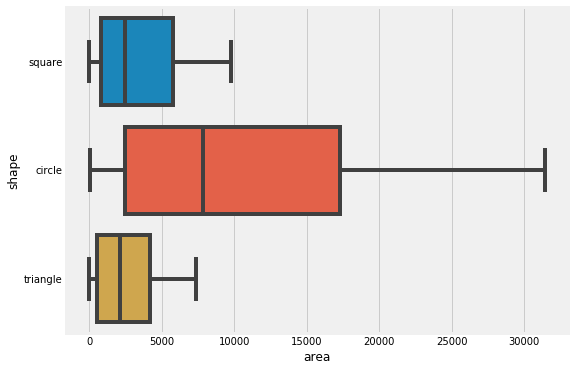

In [7]:
plt.figure(figsize=(8,6))
sns.boxplot(x='area', y='shape', data=shapes, orient='h')

2) Calculate the mean, max, and standard deviation of the area size of each color.

In [8]:
aggs = {np.mean, np.max, np.std}
by_shape = shapes.groupby('shape').agg(aggs)
by_shape

area                           
             amax          mean          std
shape                                       
circle    31415.9  10703.482500  9244.897540
square     9801.0   3411.299790  2948.724746
triangle   7350.8   2564.967742  2165.837676

3) What is the average area size of a yellow square?

In [9]:
# Groupby to get the mean area for each color-shape pair
by_col_shape = shapes.groupby(['color', 'shape'])
mean_by_col_shape = by_col_shape.mean().reset_index()

# Get the mean area value for yellow square
mask = (mean_by_col_shape['shape'] == 'square') &\
    (mean_by_col_shape['color'] == 'yellow')
mean_by_col_shape.loc[mask]['area']

9    3333.207207
Name: area, dtype: float64

4) Which shape is most likely to be green?

In [10]:
# Make table of normalized counts of color by shape
by_col_shape.size().unstack(fill_value=0).apply(lambda r: r/r.sum(), axis=1)

shape,circle,square,triangle
color,,,
blue,0.025000,0.422222,0.552778
green,0.397436,0.602564,0.000000
red,0.103448,0.193103,0.703448
yellow,0.183824,0.816176,0.000000


Looks like a square is most likely to be green.

5) Given the fact the the object is red, with an area size larger than 3,000 - what are the chances the object is a square? a triangle? a circle?

In [11]:
# Make new dataframe for red objects of size > 3000 and get normalized counts of each shape
reds = shapes.loc[(shapes['color'] == 'red') &\
                  (shapes['area'] > 3000)].reset_index()
reds['shape'].value_counts(normalize=True)

triangle    0.672
square      0.168
circle      0.160
Name: shape, dtype: float64

6) Write a function that calculates the side or radius of an object, depending on the shape and area of the object [for an Equilateral triangle - area = (side ^ 2) * sqrt(3) / 4].

In [12]:
def calc_side(shape, area):
    '''
        Given:
            shape, a string indicating a shape (circle, square, triangle)
            area, a float indicating the area of the shape
        Return:
            magnitude of side from known mathematical formula
    '''
    
    if shape == 'circle':
        return np.sqrt(area / math.pi)
    elif shape == 'square':
        return np.sqrt(area)
    else:
        return np.sqrt((4/np.sqrt(3)) * area)

7) Add a column to the dataset called "side" that shows the size matching the area in each row, round that number to the closest integer (shape side or radios).

In [13]:
shapes['side'] = shapes.apply(lambda r: calc_side(r['shape'], r['area']), axis=1)
shapes.head()

,shape,color,area,side
0,square,yellow,9409.0,97.000000
1,circle,yellow,4071.5,35.999982
2,triangle,blue,2028.0,68.435849
3,square,blue,3025.0,55.000000
4,square,blue,9216.0,96.000000


8) Draw a boxplot showing the side size distribution for each shape - what can you infer from this plot?

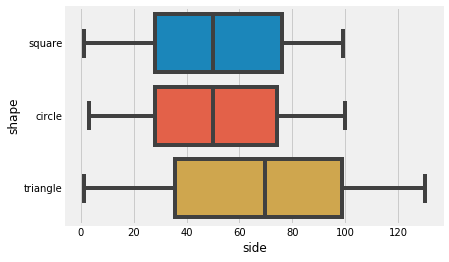

In [14]:
sns.boxplot(x='side', y='shape', data=shapes, orient='h')

Triangles in this dataset have a higher median side size over an interquartile range of generally larger values and an overall wider range of possible values relative to the other two shapes, whose side size distributions are quite similar. Taken with the output in 1), the area of a circle grows much more rapidly with side size than the other shapes, while the opposite is true for triangles.

9) Make a scatter plot with "side" on the x axis, "area" on the y axis with a different color for each shape.

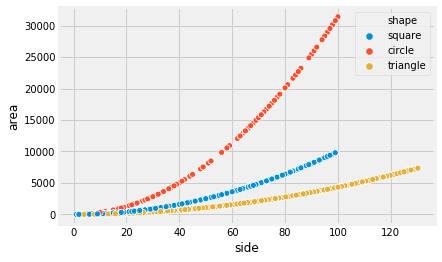

In [15]:
sns.scatterplot(x='side', y='area', hue='shape', data=shapes)

10) Create a dataframe, table or list that show for each shape:

a) The proportion of red objects within the shape

b) The proportion of blue area out of the shape's total area (sum of square inch blue area of the shape over sum of all shape size).

In [16]:
# Groupby for each color's distribution by shape
# Get the distribution of red objects 
red_object_pr = \
    by_col_shape.size().unstack(fill_value=0).\
    apply(lambda r: r/r.sum(), axis=1).T[['red']]

In [17]:
# Groupby for each color's area proportion of the total area
# Get the distriubtion for blue objects
blue_area_pr = \
    by_col_shape.sum()['area'].unstack(fill_value=0).\
    apply(lambda r: r/r.sum()).T[['blue']]

In [18]:
# Combine the above into a single dataframe
new_df = pd.concat([red_object_pr, blue_area_pr], axis=1).\
    rename(columns = {'red': 'Red Object Prop', 'blue': 'Blue Area Prop'}).\
    reset_index()
new_df.columns.name = None
new_df

,shape,Red Object Prop,Blue Area Prop
0,circle,0.103448,0.061246
1,square,0.193103,0.360385
2,triangle,0.703448,0.473886


11) Create a function that calculates 10. b. for a given shape and color.

I assumed that there is a dataframe of shapes that at least has columns for shape, color, area as given that can be passed to this function. I did not assume that any shape/color arguments (really mainly shape) would have at least one observation with a non-zero area.

In [19]:
def color_area_prop(df, shape, color):
    '''
        Given:
            df, a dataframe of shapes with shape, color, and area columns
            shape, a string indicating the shape
            color, a string indicating the color of the shape
        Return:
            the proportion of the shape's overall area that have the given color
    '''
    
    shape_only = df.loc[df['shape'] == shape]
    try:
        return shape_only.loc[shape_only['color'] == color]['area'].\
            sum() / shape_only['area'].sum()
    except:
        return 0.0

In [20]:
color_area_prop(shapes, 'circle', 'blue')

0.06124595429571636

In [21]:
color_area_prop(shapes, 'square', 'blue')

0.36038508102925904

In [22]:
color_area_prop(shapes, 'triangle', 'blue')

0.4738855857023727